<a href="https://colab.research.google.com/github/Coreight98/Paran_ajou_Project_Anything/blob/main/Pattern_model_basis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import PIL
import time
from sklearn.neighbors import KNeighborsClassifier

--Train Images--
Num of All Images:  1280
cuda 로 학습
Finished Training
[[ 114  606 1004 1280]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


find!
2
find!
2
find!
0
find!
0


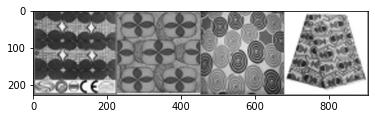

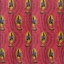

In [53]:
train_location = './drive/MyDrive/data/pattern/'

X = np.empty((0, 4), dtype=int)

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=3,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 16, kernel_size=3,stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 
        self.fc = torch.nn.Linear(50176, 5, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        global X
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        X = np.append(X,out.detach().numpy())
        return out

class PatternDataset():
    def __init__(self, image, mode, transforms):
        super().__init__()
        self.image = image
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, index):
        image_name = self.image[index]
        image = Image.open(train_location + image_name)
        image = image.resize((224,224))

        if self.mode == 'train' :
            image = self.transforms(image)
            label=1
            return image,label
        elif self.mode == 'test':
            image = self.transforms(image)
            label=1
            return image, label

    def __len__(self):
        return len(self.image)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

if __name__ == '__main__':
    #데이터 셋 불러오고 정규화
    transform = transforms.Compose(
        [transforms.Grayscale(num_output_channels=1),
         transforms.ToTensor(),
          transforms.Normalize((0.5),(0.5))
          ]
    )
    
    train_images = os.listdir(train_location)
    # test_images = os.listdir(test_location)
    print("--Train Images--")
    print("Num of All Images: ", len(train_images))

    # 데이터 셋 생성
    train_dataset = PatternDataset(train_images, mode='train', transforms=transform)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=0)
    
    # net = CNN()
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print (device,"로 학습")

    #신경망 학습하기
    # for i, data in enumerate(trainloader,0):
    #     inputs, labels = data  # data입력
    #     outputs = net(inputs)

    # np.save('./drive/MyDrive/data/pattern.npy', X)
    print('Finished Training')
    PATH = './drive/MyDrive/data/Pattern_net.pth'
    # torch.save(net, PATH)


######################################################################

    net = torch.load(PATH)
    net.eval()
    X = np.load('./drive/MyDrive/data/pattern.npy')
    # print(X)
    img=PIL.Image.open('./drive/MyDrive/data/pattern/0002.jpg')
    img = img.resize((224,224))
    emp = torch.empty(1,1,224,224)
    img_t =transform(img)
    emp[0] = img_t
    input = net(emp)

    X = np.reshape(X,(1281,5)) #1281개 5개tensor
    Y = np.ones((1281,1),dtype=int)

    reg = KNeighborsClassifier(n_neighbors=4)
    reg.fit(X,Y)
    l = reg.kneighbors(input.detach().numpy(),n_neighbors=4,return_distance=False)
    
    l.sort()
    print(l)

    for i in l:
      temp = np.empty((0,4),dtype=int)
      temp = np.append(temp, X[i])
    temp = np.reshape(temp,(4,5))

    dataiter = iter(trainloader)
    
    count = 0
    
    index=0
    
    images = torch.empty(4,1,224,224)


    while(index<4):
      if count < l[0][index]:
        imgg=img
        img=dataiter.next()
        count+=4
      else:
        print("find!")
        #l[0][index]-count 한 값을 인덱스로 dataiter에서 출력
        k=count-l[0][index]
        print(k)
        if k == 0:
          images[index][0] = img[0][k][0]
        else:
          images[index][0] = imgg[0][4-k][0]
        count+=4
        index+=1
        if index != 4:
          dataiter.next()
        
    #이미지 출력
    imshow(torchvision.utils.make_grid(images))

    from IPython.display import Image 
    img=Image('./drive/MyDrive/data/pattern/0002.jpg')
    display(img)